In [1]:
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt

In [2]:
words = open("./names.txt").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [4]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random

random.seed(42)
random.shuffle(words)
n8 = int(0.8 * len(words))
n9 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n8])
Xde, Yde = build_dataset(words[n8:n9])
Xte, Yte = build_dataset(words[n9:])

print(Xtr.shape, Ytr.shape)
print(Xde.shape, Yde.shape)
print(Xte.shape, Yte.shape)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Looking at Weight Init

In [5]:
n_emb = 10 # number of embedding dim
n_hidden = 200 # number of hidden neurons

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [6]:
max_steps = 200000
batch_size = 32
lossi = []

for k in range(max_steps):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # (batch_size, block_size, n_emb)
    embcat = emb.view(emb.shape[0], n_emb * block_size)
    hpreact = embcat @ W1 + b1 # (batch_size, n_hidden)
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 #(batch_size, vocab_size)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update params
    lr = 0.1 if k < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    if k % 10000 == 0:
        print(f"{k:7d}/{max_steps:7d} {loss.item():.4f}")
        
    lossi.append(loss.log10().item())

      0/ 200000 26.0674
  10000/ 200000 2.2853
  20000/ 200000 2.7830
  30000/ 200000 2.2377
  40000/ 200000 2.5488
  50000/ 200000 2.4466
  60000/ 200000 2.2081
  70000/ 200000 2.3391
  80000/ 200000 1.9113
  90000/ 200000 2.0726
 100000/ 200000 2.5233
 110000/ 200000 2.2451
 120000/ 200000 2.2481
 130000/ 200000 1.8928
 140000/ 200000 1.8328
 150000/ 200000 2.0571
 160000/ 200000 2.3397
 170000/ 200000 2.1798
 180000/ 200000 1.8868
 190000/ 200000 1.9591


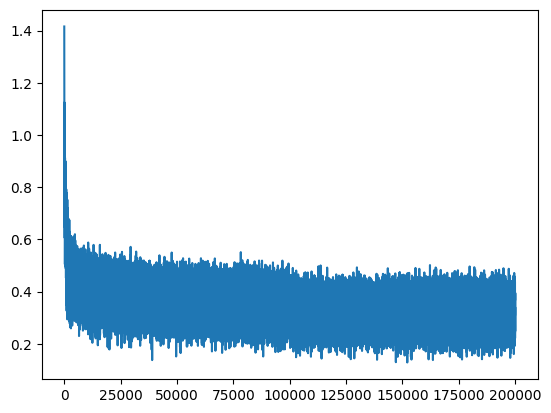

In [7]:
plt.plot(lossi)

In [8]:
@torch.no_grad() # disables grad tracking
def split_loss(split):
    X, Y = {
        "train": (Xtr, Ytr),
        "dev": (Xde, Yde),
        "test": (Xte, Yte)
    }[split]
    emb = C[X]
    h = torch.tanh( emb.view(-1, 30) @ W1 + b1 )
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(split, loss.item()) 

split_loss('train')
split_loss('dev')

train 2.122992753982544
dev 2.167567729949951


In [9]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    context = [0] * block_size
    out = []
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, 10)
        h = torch.tanh( emb.view(-1, n_emb * block_size) @ W1 + b1 )
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        if ix == 0:
            break
        context = context[1:] + [ix]
        out.append(itos[ix])
    
    print(''.join(out))

carmah
amelle
khi
mili
taty
salaysie
rah
tafamdryst
kaeli
ner
kia
chaiiv
kaleigh
ham
jory
quinn
sulivea
jadii
wajt
madiaryxik


### There are 2 issues with training this network

#### 1. Notice loss at 0 is high 

**loss_0 = ~25 and rapidly comes down** - Weights Init is messed up

You would typically want loss such that logits are either 0 or equally distributed initially with a little bit of entropy for exploration. So loss at step 0 should be ~$-\log(1/27.0)$ where 27 is n_class

In [10]:
- torch.tensor(1 / 27.0).log()

tensor(3.2958)

In [11]:
# 4-deminsional example of the issue
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0) # Uniform probs
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In [12]:
# 4-deminsional example of the issue
# logits = torch.tensor([-3.0, 5.0, 0.0, 4.0])
logits = torch.randn(4) * 100
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([1.0000e+00, 0.0000e+00, 1.8959e-33, 0.0000e+00]), tensor(75.3456))

Solution

1. Set last bias to 0s
2. Set the weights to have low values.

Note: Setting to zero might give us the exact loss we are looking for, but it might result in dead neurons.

In [13]:
n_emb = 10  # number of embedding dim
n_hidden = 200  # number of hidden neurons

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # <----
b2 = torch.randn(vocab_size, generator=g) * 0 # <-----

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [16]:
max_steps = 200000
batch_size = 32
lossi = []
h_first, hpreact_first = None, None

for k in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]  # (batch_size, block_size, n_emb)
    embcat = emb.view(emb.shape[0], n_emb * block_size)
    hpreact = embcat @ W1 + b1  # (batch_size, n_hidden)
    h = torch.tanh(hpreact)
    if h_first is None:
        hpreact_first = hpreact
        h_first = h
    logits = h @ W2 + b2  # (batch_size, vocab_size)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update params
    lr = 0.1 if k < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    if k % 10000 == 0:
        print(f"{k:7d}/{max_steps:7d} {loss.item():.4f}")

    lossi.append(loss.log10().item())

      0/ 200000 3.2014
  10000/ 200000 2.9326
  20000/ 200000 1.9115
  30000/ 200000 2.6776
  40000/ 200000 2.0292
  50000/ 200000 2.1914
  60000/ 200000 2.3891
  70000/ 200000 2.2798
  80000/ 200000 2.2999
  90000/ 200000 2.7477
 100000/ 200000 2.4051
 110000/ 200000 2.3074
 120000/ 200000 2.1180
 130000/ 200000 1.9129
 140000/ 200000 1.8783
 150000/ 200000 2.0198
 160000/ 200000 2.3820
 170000/ 200000 2.1228
 180000/ 200000 2.0255
 190000/ 200000 1.8847


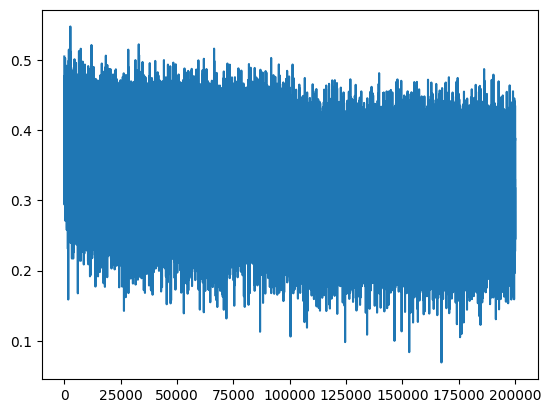

In [17]:
plt.plot(lossi)

In [18]:
@torch.no_grad()  # disables grad tracking
def split_loss(split):
    X, Y = {"train": (Xtr, Ytr), "dev": (Xde, Yde), "test": (Xte, Yte)}[split]
    emb = C[X]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(split, loss.item())


split_loss("train")
split_loss("dev")

train 2.0690250396728516
dev 2.130821943283081


#### 2. Dead Neurons

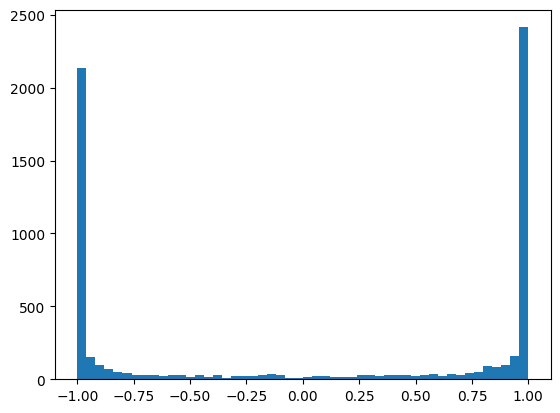

In [22]:
plt.hist(h_first.view(-1).tolist(), bins=50);

Tanh activations are saturated to -1s and 1.

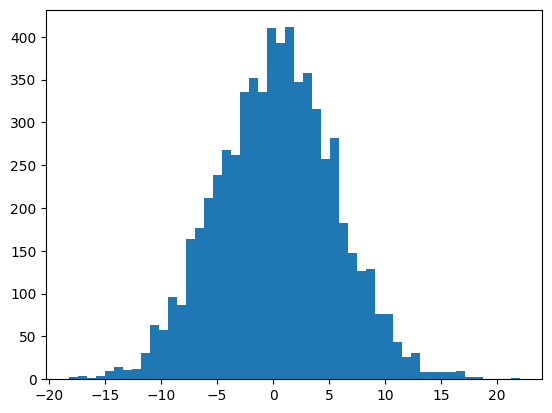

In [24]:
plt.hist(hpreact_first.view(-1).tolist(), bins=50);

H preactivations are every brawd. from -15 to 15, causing tanh to mostly saturate at -1 and 1.

Why this is a problem. - Because tanh's gradient at -1 or 1 is zero. If during init all inputs to that neuron produces -1 or 1. This neuron won't learn anything at any point as the gradient passing through this will be zero out - Causing this neuron to be dead

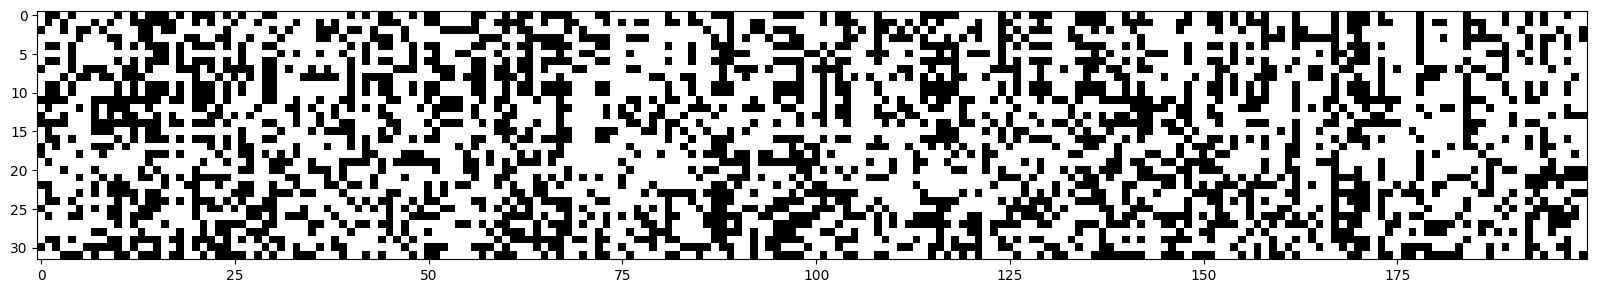

In [27]:
plt.figure(figsize=(20, 10))
plt.imshow(h_first.abs() > 0.99, cmap='gray', interpolation='nearest') # White true, black false

We are lucky here, as there no column that is entirely white / true, so no dead neuron

**This can happen to other activations as well**

**This can happen in the middle of training as well, when learning rate is very high causing neurons/activations to saturate at position where grads would be zero - causing brain damage**

In [28]:
n_emb = 10  # number of embedding dim
n_hidden = 200  # number of hidden neurons

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * 0.2 # <---------
b1 = torch.randn(n_hidden, generator=g)                         * 0 # <----
W2 = torch.randn((n_hidden, vocab_size), generator=g)           * 0.01 # <----
b2 = torch.randn(vocab_size, generator=g)                       * 0 # <-----

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [29]:
max_steps = 200000
batch_size = 32
lossi = []
h_first, hpreact_first = None, None

for k in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]  # (batch_size, block_size, n_emb)
    embcat = emb.view(emb.shape[0], n_emb * block_size)
    hpreact = embcat @ W1 + b1  # (batch_size, n_hidden)
    h = torch.tanh(hpreact)
    if h_first is None:
        hpreact_first = hpreact
        h_first = h
    logits = h @ W2 + b2  # (batch_size, vocab_size)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update params
    lr = 0.1 if k < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    if k % 10000 == 0:
        print(f"{k:7d}/{max_steps:7d} {loss.item():.4f}")

    lossi.append(loss.log10().item())

      0/ 200000 3.2987
  10000/ 200000 2.5487
  20000/ 200000 1.9624
  30000/ 200000 2.0648
  40000/ 200000 1.9943
  50000/ 200000 2.4095
  60000/ 200000 2.4558
  70000/ 200000 2.0860
  80000/ 200000 2.0377
  90000/ 200000 2.2253
 100000/ 200000 2.0259
 110000/ 200000 2.1193
 120000/ 200000 2.0062
 130000/ 200000 1.9672
 140000/ 200000 2.2304
 150000/ 200000 1.7442
 160000/ 200000 1.9483
 170000/ 200000 2.0644
 180000/ 200000 2.1272
 190000/ 200000 2.2469


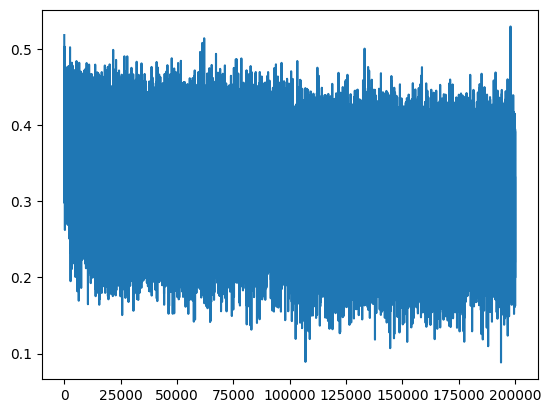

In [30]:
plt.plot(lossi)

In [31]:
@torch.no_grad()  # disables grad tracking
def split_loss(split):
    X, Y = {"train": (Xtr, Ytr), "dev": (Xde, Yde), "test": (Xte, Yte)}[split]
    emb = C[X]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(split, loss.item())


split_loss("train")
split_loss("dev") 

train 2.03790545463562
dev 2.1020028591156006


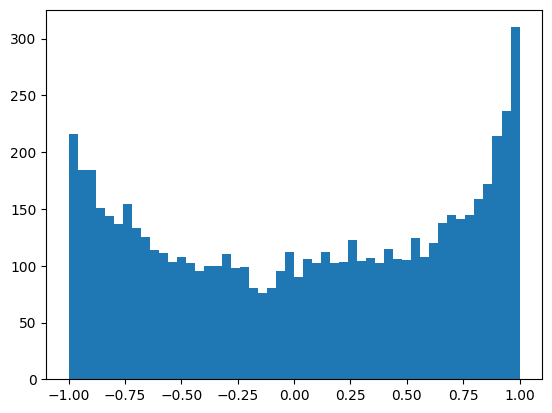

In [32]:
plt.hist(h_first.view(-1).tolist(), bins=50);

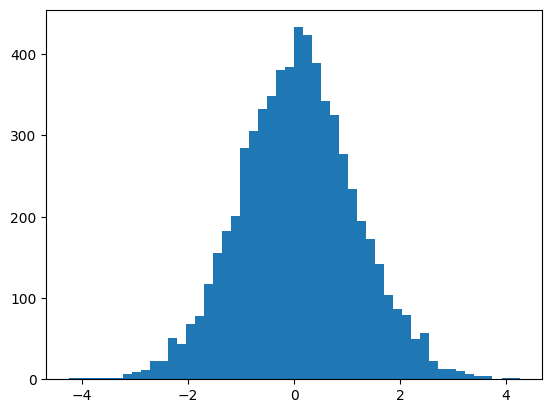

In [33]:
plt.hist(hpreact_first.view(-1).tolist(), bins=50);

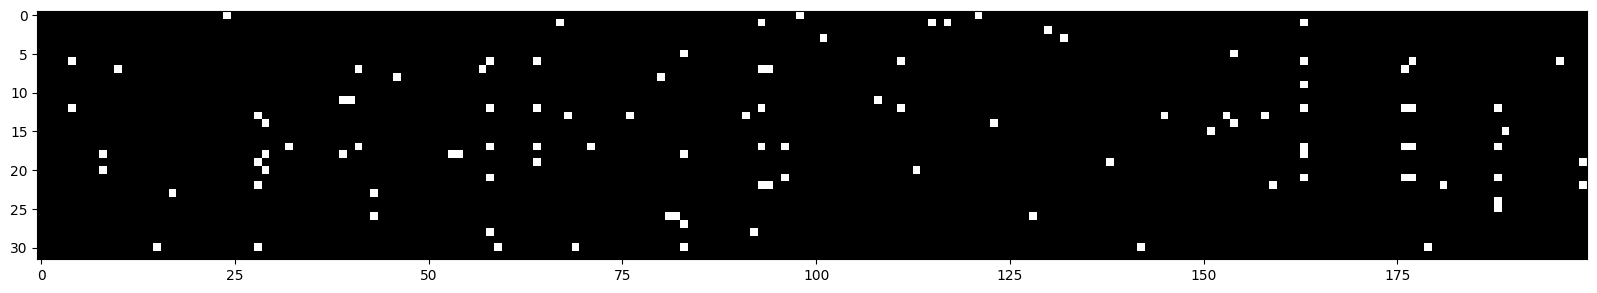

In [34]:
plt.figure(figsize=(20, 10))
plt.imshow(h_first.abs() > 0.99, cmap='gray', interpolation='nearest') # White true, black false

Much better with a little bit of entropy

### Closer look at standard init'ing

While these numbers weight scales are set manually, this almost never done when training NNs cause there are some ways of init'ing perform the same thing automatically.

tensor(0.0115) tensor(0.9979)
tensor(-0.0041) tensor(3.1209)


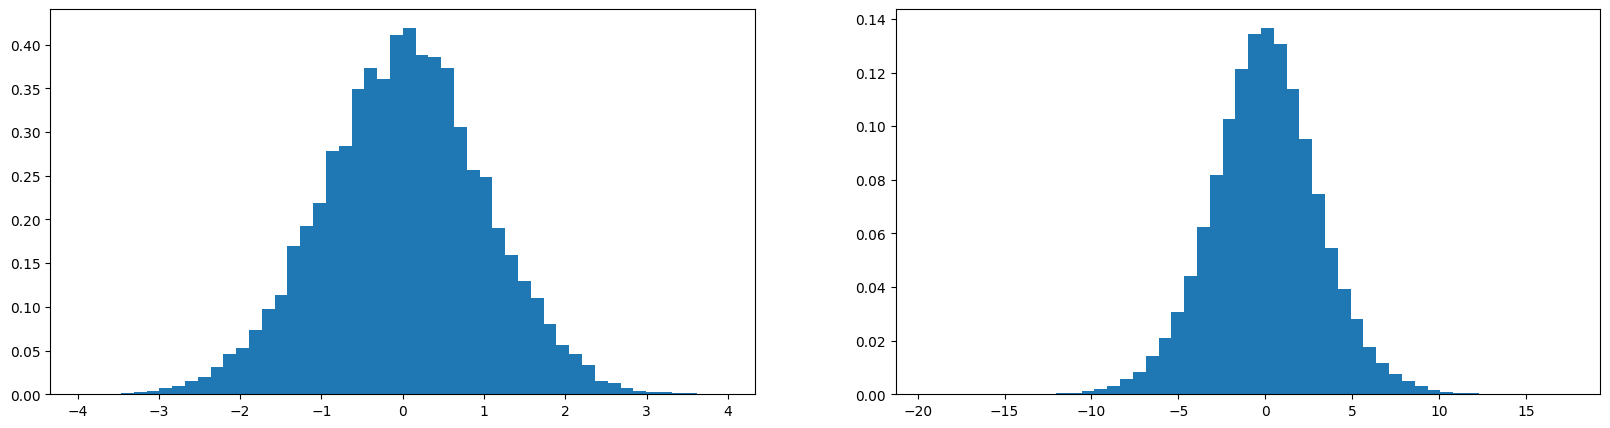

In [36]:
X = torch.randn(1000, 10)
W = torch.randn(10, 200)
y = X @ W # forget bias and non liniearity
print(X.mean(), X.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(X.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

If we see X's std is 1 as expected with randn init, but y's std is expanded to 3.12. This is the problem causing y to take extreme randes (-10 to 10 in the plot) causing activations to take extreme (no grad) positions

Solution: the wieght scale should be set to $\frac{1}{\sqrt{fann}}$ where $fann$ is input dimension (in prev example 10)

tensor(0.0127) tensor(0.9951)
tensor(-0.0016) tensor(1.0184)


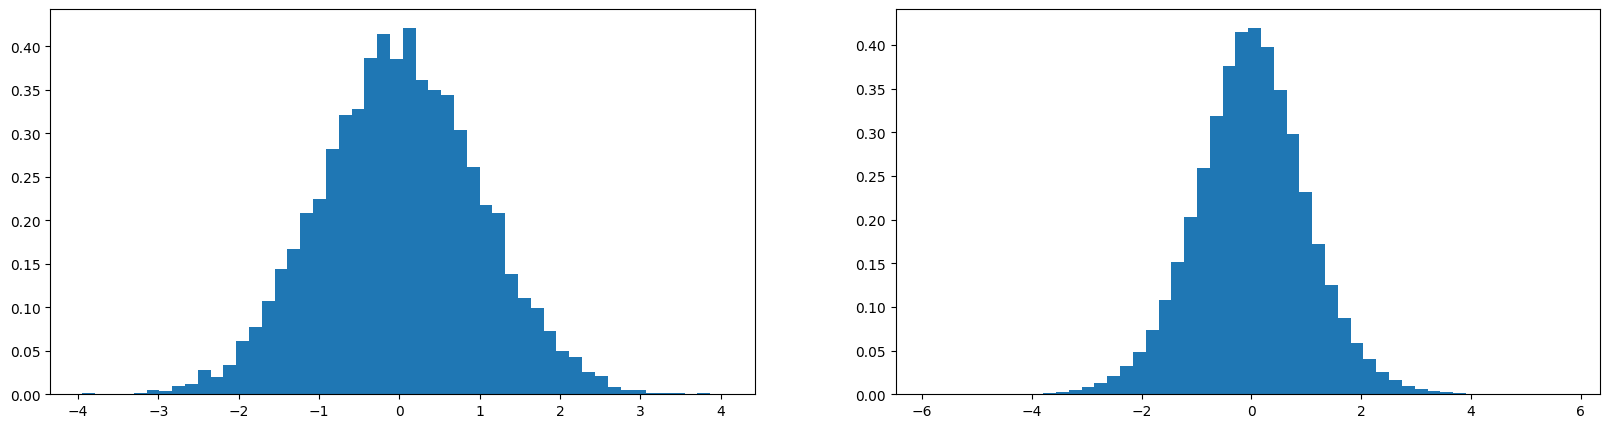

In [37]:
X = torch.randn(1000, 10)
W = torch.randn(10, 200) / 10**0.5
y = X @ W # forget bias and non liniearity
print(X.mean(), X.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(X.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

Now considering activations check [this paper](https://arxiv.org/pdf/1502.01852). This paper looked at CNNs with ReLU, PReLU but almost the same thing can be replicated to other actiovations as well.

Quick TLDR:

- Since ReLU is a squashing function that removes -ve values - half of the distribution is lost so the weight stddev should be $\sqrt{\frac{2}{fann}}$
- If forward pass is properly init'd then backward pass it taken care of but up to point of depth of the NN - See paper.

pytorch implementation - https://docs.pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_

Extanding same for tanh the weight stddev will be 

$$\frac{\frac{5}{3}}{\sqrt{fann}}$$

In [45]:
(5/3) / ((n_emb * block_size) ** 0.5)

0.3042903097250923

In [46]:
n_emb = 10  # number of embedding dim
n_hidden = 200  # number of hidden neurons

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g)   * ((5/3) / ((n_emb * block_size) ** 0.5)) # 0.2 (old) # <---------
b1 = torch.randn(n_hidden, generator=g)                         * 0 # <----
W2 = torch.randn((n_hidden, vocab_size), generator=g)           * 0.01 # <----
b2 = torch.randn(vocab_size, generator=g)                       * 0 # <-----

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [47]:
max_steps = 200000
batch_size = 32
lossi = []
h_first, hpreact_first = None, None

for k in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]  # (batch_size, block_size, n_emb)
    embcat = emb.view(emb.shape[0], n_emb * block_size)
    hpreact = embcat @ W1 + b1  # (batch_size, n_hidden)
    h = torch.tanh(hpreact)
    if h_first is None:
        hpreact_first = hpreact
        h_first = h
    logits = h @ W2 + b2  # (batch_size, vocab_size)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update params
    lr = 0.1 if k < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    if k % 10000 == 0:
        print(f"{k:7d}/{max_steps:7d} {loss.item():.4f}")

    lossi.append(loss.log10().item())

      0/ 200000 3.2752
  10000/ 200000 2.3827
  20000/ 200000 1.9351
  30000/ 200000 2.4374
  40000/ 200000 2.5588
  50000/ 200000 2.4022
  60000/ 200000 2.5538
  70000/ 200000 1.8471
  80000/ 200000 2.0225
  90000/ 200000 2.1686
 100000/ 200000 2.2555
 110000/ 200000 2.0041
 120000/ 200000 1.9330
 130000/ 200000 2.0789
 140000/ 200000 1.9286
 150000/ 200000 2.0561
 160000/ 200000 2.1031
 170000/ 200000 2.2502
 180000/ 200000 1.9499
 190000/ 200000 1.9769


In [48]:
@torch.no_grad()  # disables grad tracking
def split_loss(split):
    X, Y = {"train": (Xtr, Ytr), "dev": (Xde, Yde), "test": (Xte, Yte)}[split]
    emb = C[X]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(split, loss.item())


split_loss("train")
split_loss("dev") 

train 2.0387256145477295
dev 2.1051247119903564


### Weight Init Conclusion

These precise setting is almost made obsolete because of modern day innovations namely

1. Residual Connections
2. Normalization layers like Batch Norm, Layer Norm, Instance Norm etc
3. More powerfull optimizers like RMSProp, Adam etc

## Batch Normalization

Batch Normalization is a technique to stabilize and speed up training in deep neural networks by normalizing the inputs of each layer.

- It does this by normalizing the hidden state to be roughly gaussian. Gaussian initally, later allows scaling and shifting the normalized values with learned parameters (gamma, beta) to maintain model capacity.
- Helps reduce internal covariate shift (changing input distributions).
- Leads to stable training, reduced dependence on weight init'n and learning rate (to an extent)
- Often leads to better generalization - as the gamma, betta changes -> leads to tiny changes in input -> leading to generalization.

**Con**
- Samples are "combined / coupled" inside a batch. This can be good as regularizer

### Formulation

**Init**
$$
\gamma = \mathbf{1}_{1 \times m}, \quad \beta = \mathbf{0}_{1 \times m}
$$
where $m$ is batch size

**During Training**

Hidden state will be normalized
$$
\mu_B = \frac{1}{m} \sum_{i=1}^m x_i \\
\sigma_B^2 = \frac{1}{m} \sum_{i=1}^m (x_i - \mu_B)^2 \\
\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
$$
$\epsilon$ is usually $e^{-5}$ to prevent divide by 0

Normalized preactvations will be scaled and shifted using $\gamma$ and $\beta$
$$
\hat{x}_i = \gamma \hat{x}_i + \beta
$$

Typically running $\mu$ and $\sigma$ will be maintained to be used during inference
$$
\mu_{\text{running}} \leftarrow (1 - \alpha) \cdot \mu_{\text{running}} + \alpha \cdot \mu_B \\
\alpha = 0.001
$$

**During Inference**

hidden states are normalized using running stats maintained during training
$$
\hat{x}_i = \frac{x_i - \mu_{\text{running}}}{\sqrt{\sigma^2_{\text{running}} + \epsilon}}
$$

Normalized preactvations will be scaled and shifted using $\gamma$ and $\beta$
$$
\hat{x}_i = \gamma \hat{x}_i + \beta
$$

In [62]:
n_emb = 10  # number of embedding dim
n_hidden = 200  # number of hidden neurons

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g)   * ((5/3) / ((n_emb * block_size) ** 0.5)) # 0.2 (old) # <---------
# b1 = torch.randn(n_hidden, generator=g)                         * 0 # <----
W2 = torch.randn((n_hidden, vocab_size), generator=g)           * 0.01 # <----
b2 = torch.randn(vocab_size, generator=g)                       * 0 # <-----

# ---------- Batch Normalization Param -------
## -- Learnable PArams
bngain = torch.ones((1, n_hidden))  # gamma
bnbias = torch.zeros((1, n_hidden))  # beta
## -- Running stats
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
# ---------------------------------------------

# parameters = [C, W1, b1, W2, b2, bnbias, bngain]
parameters = [C, W1, W2, b2, bnbias, bngain] # bias removed
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [63]:
max_steps = 200000
batch_size = 32
lossi = []

for k in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]  # (batch_size, block_size, n_emb)
    embcat = emb.view(emb.shape[0], n_emb * block_size)
    hpreact = embcat @ W1 # + b1  # (batch_size, n_hidden)
    
    # -------- Batch Normalization ---------
    
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
        
    # --------------------------------------
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2  # (batch_size, vocab_size)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update params
    lr = 0.1 if k < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    if k % 10000 == 0:
        print(f"{k:7d}/{max_steps:7d} {loss.item():.4f}")

    lossi.append(loss.log10().item())

      0/ 200000 3.3077
  10000/ 200000 2.3406
  20000/ 200000 2.0351
  30000/ 200000 2.0083
  40000/ 200000 2.2079
  50000/ 200000 2.2869
  60000/ 200000 2.0623
  70000/ 200000 1.8437
  80000/ 200000 1.9519
  90000/ 200000 2.2801
 100000/ 200000 2.4778
 110000/ 200000 2.4236
 120000/ 200000 2.4934
 130000/ 200000 1.6808
 140000/ 200000 2.0282
 150000/ 200000 1.9820
 160000/ 200000 2.1588
 170000/ 200000 2.4927
 180000/ 200000 2.4751
 190000/ 200000 2.1679


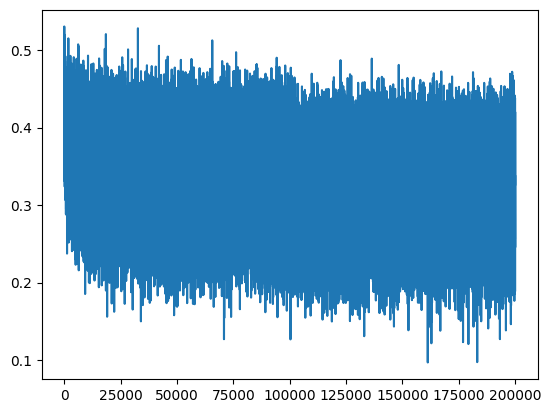

In [64]:
plt.plot(lossi)

In [66]:
@torch.no_grad()  # disables grad tracking
def split_loss(split):
    X, Y = {"train": (Xtr, Ytr), "dev": (Xde, Yde), "test": (Xte, Yte)}[split]
    emb = C[X]
    hpreact = emb.view(-1, 30) @ W1 # + b1
    # -------- Batch Normalization ---------
    hpreact = (bngain * (hpreact - bnmean_running) / bnstd_running + bnbias)
    # -------------------------------------
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(split, loss.item())


split_loss("train")
split_loss("dev")

train 2.066974639892578
dev 2.1081862449645996


**Note** biases are useless as the hidden state is normalized. so not be wastefull as set `use_bias=False` in Linear (/Conv) layers when using batch norm